In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [56]:

def load_data(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return pd.json_normalize(data)

route = "../lighthouse/results/"
files = {
    "react_desktop": route + "react_desktop/dashboard/results.json",
    "vue_desktop": route + "vue_desktop/dashboard/results.json",
    "react_mobile": route + "react_mobile/dashboard/results.json",
    "vue_mobile": route + "vue_mobile/dashboard/results.json"
}

dataframes = {name: load_data(path) for name, path in files.items()}

dataframes["react_desktop"].head()
dataframes["vue_desktop"].head()
#dataframes["react_mobile"].head()
#dataframes["vue_mobile"].head()


,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.98,0.8 s,1.1 s,0.8 s,0 ms,0
1,1.00,0.5 s,0.8 s,0.5 s,0 ms,0
2,0.99,0.6 s,0.8 s,0.6 s,0 ms,0
3,0.98,0.8 s,1.0 s,0.8 s,0 ms,0
4,0.88,1.4 s,1.7 s,1.4 s,0 ms,0


In [ ]:
# Convert metrics to numeric
def convert_metrics(df):
    for metric in ["metrics.firstContentfulPaint", "metrics.largestContentfulPaint", "metrics.timeToInteractive"]:
        # Remove strings convert seconds to milliseconds
        df[metric] = df[metric].str.replace(r"[^\d.]", "", regex=True).astype(float) * 1000

    # Convert totalBlockingTime to numeric (its already in milliseconds)
    df["metrics.totalBlockingTime"] = df["metrics.totalBlockingTime"].str.replace(r"[^\d.]", "", regex=True).astype(float)

    # Convert cumulativeLayoutShift to numeric (unitless)
    df["metrics.cumulativeLayoutShift"] = df["metrics.cumulativeLayoutShift"].astype(float)

    return df

dataframes = {name: convert_metrics(df.copy()) for name, df in dataframes.items()}


In [ ]:

# Normalize metrics, with min-max normalization
def normalize_metrics(df):
    metrics_to_normalize = ["metrics.firstContentfulPaint", "metrics.largestContentfulPaint",
                            "metrics.timeToInteractive", "metrics.totalBlockingTime", 
                            "metrics.cumulativeLayoutShift"]

    for metric in metrics_to_normalize:
        min_val = df[metric].min()
        max_val = df[metric].max()
        # Avoid division by zero 
        if max_val != min_val:
            df[metric] = (df[metric] - min_val) / (max_val - min_val)
        else:
            df[metric] = 0  

    return df

dataframes_normalized = {name: normalize_metrics(df.copy()) for name, df in dataframes.items()}


In [59]:
dataframes_normalized["react_desktop"].head()
#dataframes_normalized["vue_desktop"].head()

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
0,0.99,0.125,0.000000,0.000000,0.0,0
1,0.99,0.125,0.142857,0.000000,0.0,0
2,0.99,0.125,0.142857,0.142857,0.0,0
3,0.99,0.125,0.000000,0.142857,0.0,0
4,0.99,0.125,0.000000,0.000000,0.0,0


In [ ]:
# Set the origimnal dataframes to the normalized ones
dataframes = dataframes_normalized

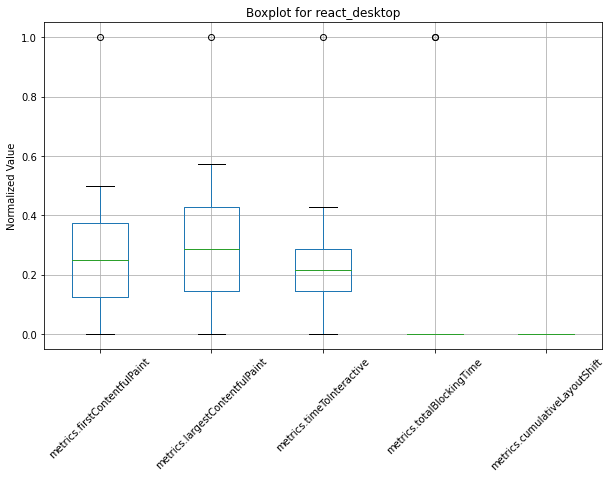

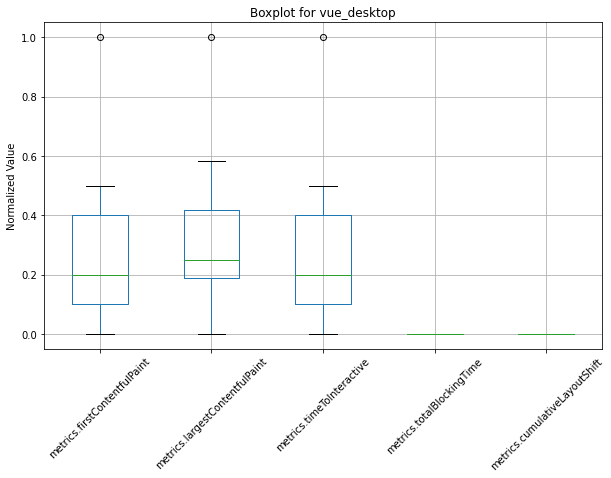

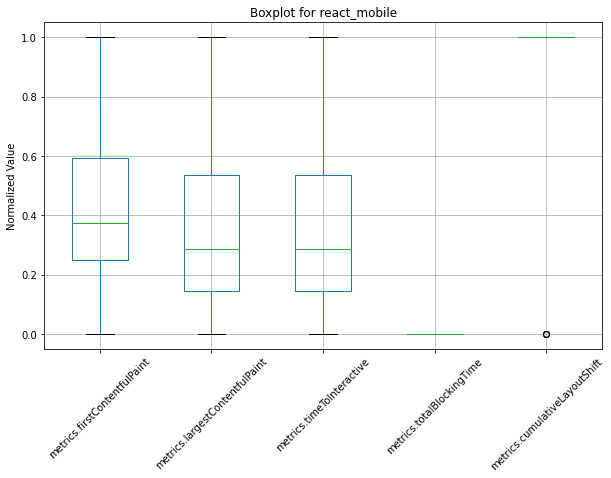

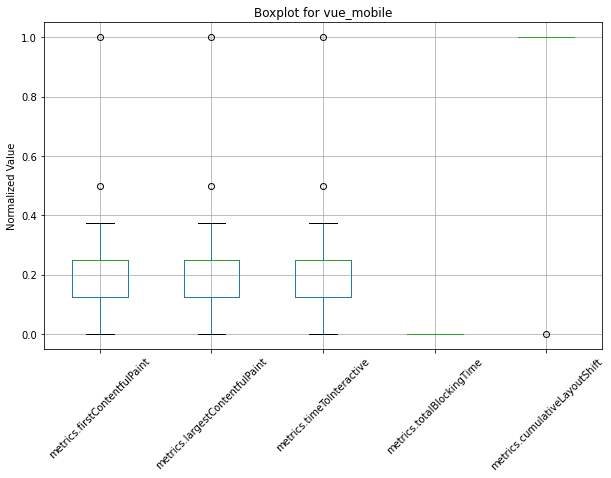

In [ ]:
# Detect outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))]
    return outliers

outliers = {name: {col: detect_outliers(df, col) for col in df.columns if "metrics" in col} for name, df in dataframes.items()}

outliers["react_desktop"]["metrics.firstContentfulPaint"]

# Plotting boxplots for each dataset
for name, df in dataframes.items():
    plt.figure(figsize=(10, 6))
    df.boxplot(column=[col for col in df.columns if "metrics" in col])
    plt.title(f"Boxplot for {name}")
    plt.ylabel("Normalized Value")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
from tabulate import tabulate

for dataset_name, metrics_outliers in outliers.items():
    print(f"\nOutliers for {dataset_name}:\n")
    for metric, outlier_df in metrics_outliers.items():
        if not outlier_df.empty:
            print(f"\n  Outliers in {metric}:\n")
            print(tabulate(outlier_df, headers='keys', tablefmt='grid'))
        else:
            print(f"\n  No outliers in {metric}.")



Outliers for react_desktop:


  Outliers in metrics.firstContentfulPaint:

+----+---------------+--------------------------------+----------------------------------+-----------------------------+-----------------------------+---------------------------------+
|    |   performance |   metrics.firstContentfulPaint |   metrics.largestContentfulPaint |   metrics.timeToInteractive |   metrics.totalBlockingTime |   metrics.cumulativeLayoutShift |
+====+===============+================================+==================================+=============================+=============================+=================================+
| 12 |          0.91 |                              1 |                                1 |                           1 |                           0 |                               0 |
+----+---------------+--------------------------------+----------------------------------+-----------------------------+-----------------------------+---------------------------------+

In [20]:
outlier_df

,performance,metrics.firstContentfulPaint,metrics.largestContentfulPaint,metrics.timeToInteractive,metrics.totalBlockingTime,metrics.cumulativeLayoutShift
1,1,0.8,0.8,0.8,0.0,0.0


In [ ]:

# # Statistics
# def get_statistics(df):
#     stats = df.describe().loc[["mean", "50%", "std"]].rename(index={"50%": "median"})
#     return stats

# statistics = {name: get_statistics(df) for name, df in dataframes.items()}
